Ce cahier vise à classer les départements de France métropolitaine à partir des données sur les crimes et délits.

On cherche à visualiser l'évolution des clusters dans le temps. Après plusieurs tests, les périodes les probantes à une analyse sont les périodes 2000-2013 et 2014-2020

In [69]:
import warnings
warnings.filterwarnings("ignore")
import tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [70]:
security_df = pd.read_csv('full_dataset_normalized.csv',sep=",")
security_df['code_dep'] = security_df['code_dep'].astype(str)
security_df = security_df[(security_df['annee'] >= 2000) & (security_df['annee'] <= 2013)]
# On ne s'occupe pas des départements d'outre mer pour la visualisation
col_a_supprimer = ['971', '972', '973', '974', 'France_Métro']
security_df = security_df[~security_df['code_dep'].isin(col_a_supprimer)]

On ne clusterise que les données liées au crimes et délits.

In [71]:
security_df_selected_columns = security_df[['Vols_per_population',
       'Cambriolages à domicile ou violaiton de domicile_per_population',
       'Crimes ou délits sexuelles_per_population',
       'Infractions liées aux stupéfiants_per_population',
       'Dégradations ou destructions de biens volontaires_per_population',
       'Violences_per_population', 'Falsifications et contrefaçons_per_population',
       'Délits Économiques et Financiers_per_population',
       "Irégularités de Main-d'oeuvre_per_population", "code_dep"]]

On group by le numéro de département pour n'avoir qu'une donnée par département (moyenne sur les années).

In [72]:
security_df_selected_columns_by_dept = security_df_selected_columns.groupby('code_dep').mean().reset_index()

In [73]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

colonnes_pca = ['Vols_per_population',
       'Cambriolages à domicile ou violaiton de domicile_per_population',
       'Crimes ou délits sexuelles_per_population',
       'Infractions liées aux stupéfiants_per_population',
       'Dégradations ou destructions de biens volontaires_per_population',
       'Violences_per_population', 'Falsifications et contrefaçons_per_population',
       'Délits Économiques et Financiers_per_population',
       "Irégularités de Main-d'oeuvre_per_population"]


donnees_pca = security_df_selected_columns_by_dept[colonnes_pca]
donnees_pca_standardisees = StandardScaler().fit_transform(donnees_pca)

# Application de la PCA
pca = PCA()
resultats_pca = pca.fit(donnees_pca_standardisees)

Text(0.5, 1.0, 'Pourcentage de la variance des données expliquée en fonction du nombre de variables')

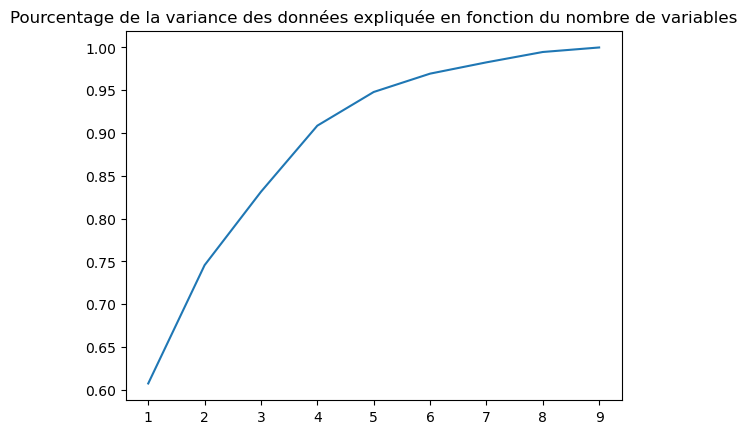

In [74]:
plt.plot(np.array([1,2,3,4,5,6,7,8,9]), np.cumsum(resultats_pca.explained_variance_ratio_))
plt.title('Pourcentage de la variance des données expliquée en fonction du nombre de variables')

In [75]:
np.cumsum(resultats_pca.explained_variance_ratio_)

array([0.60735532, 0.74560605, 0.83136757, 0.90862353, 0.94797645,
       0.96941587, 0.98261622, 0.99472481, 1.        ])

Avec 3 variables on peut exprimer 79% de la variance.

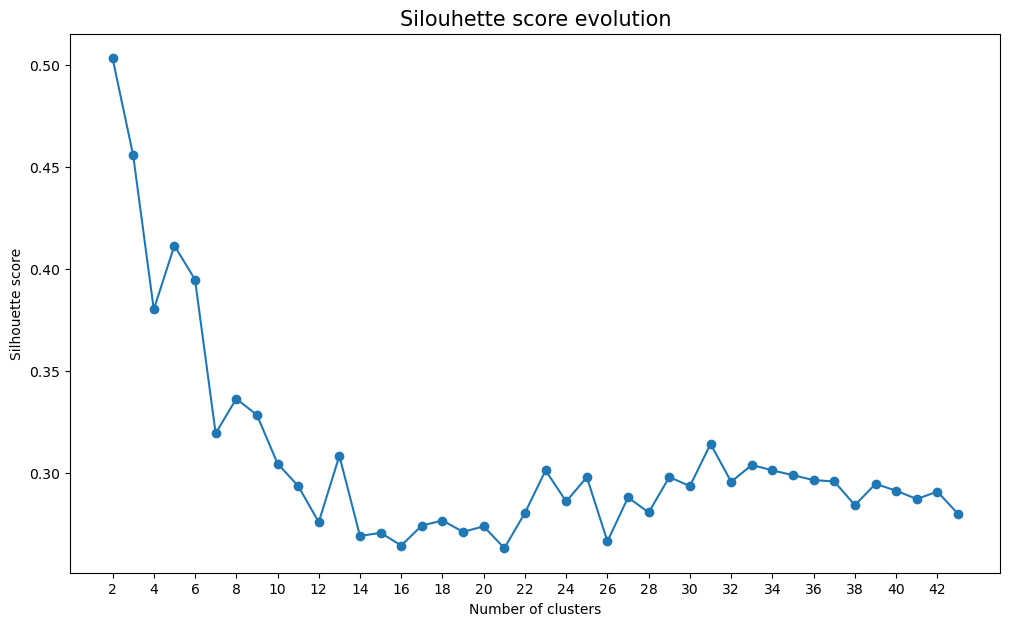

In [76]:
resultats_pca_df = pd.DataFrame(resultats_pca.transform(donnees_pca_standardisees)[:, :3], columns=['PCA1', 'PCA2', 'PCA3'])
resultats_pca_df['dept'] = security_df_selected_columns_by_dept['code_dep']

best_nb_cluster = tools.best_nb_cluster(
        resultats_pca_df,
        ['PCA1', 'PCA2', 'PCA3'],
        2,
        44,
        True,
        "Silouhette score evolution"
)

D'après le silouhette score, le meilleurs nombre de clusters à utiliser est de 2, cependant on remarque un rebond du score à 5 clusters,nous allons donc essayer une autre metrique (Elbow Score) pour décider du nombre de clusters à choisir.

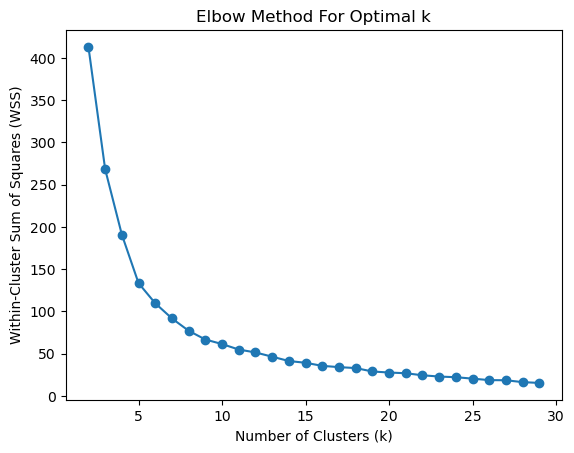

In [77]:
from sklearn.cluster import KMeans
                 
feature_columns = ['PCA1', 'PCA2', 'PCA3']
X = resultats_pca_df[feature_columns].values

wss_values = []

k_values = range(2, 30)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wss_values.append(kmeans.inertia_)

# Plot the curve of WSS versus the number of clusters (k)
plt.plot(k_values, wss_values, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.show()

Il est difficile de conclure sur le nombre optimal à partir du elbow score. Nous remarquons tout de même une légère cassure pour le nombre de cluster égal à 5. Ceci vient confirmer notre hypothèse précédente, nous allons donc utiliser ce nombre de cluster par la suite.

In [78]:
# applying 5 clusters
labels = tools.clustering(resultats_pca_df,
                 ['PCA1', 'PCA2', 'PCA3'],
                 5)

resultats_pca_df['Cluster'] = labels

departements_geojson_name = 'departements.geojson'
gdf_departements = gpd.read_file(departements_geojson_name)

# Fusionner seulement la colonne "Cluster" dans le GeoDataFrame
gdf_departements['Cluster'] = gdf_departements['code'].astype(str).map(resultats_pca_df.set_index('dept')['Cluster'])

In [79]:
# On calcule le score moyen de chaque cluster pour pouvoir les ordonner. Ainsi les couleurs auront plus de sens
weighted_scores = resultats_pca_df.groupby('Cluster')['PCA1'].mean() * resultats_pca.explained_variance_ratio_[0] + resultats_pca_df.groupby('Cluster')['PCA2'].mean() * resultats_pca.explained_variance_ratio_[1] + resultats_pca_df.groupby('Cluster')['PCA3'].mean() * resultats_pca.explained_variance_ratio_[2]

sorted_cluster_indices = np.argsort(weighted_scores)
replacement_dict = {cluster: rank for rank, cluster in enumerate(sorted_cluster_indices)}
gdf_departements['Cluster'] = gdf_departements['Cluster'].replace(replacement_dict)

<Figure size 1200x800 with 0 Axes>

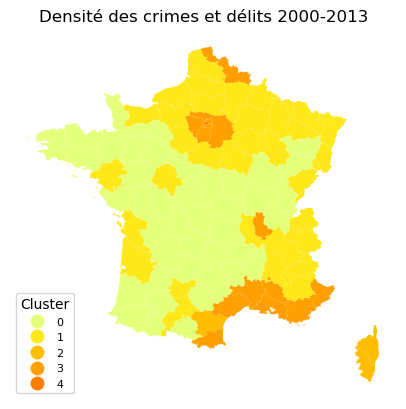

In [80]:
plt.figure(figsize=(12, 8))
vmin, vmax = gdf_departements['Cluster'].min(), gdf_departements['Cluster'].max()
gdf_departements.plot(column='Cluster', legend=True, cmap='Wistia',
                  categorical=True, edgecolor='none',
                  legend_kwds={'fontsize': 8, 'title': "Cluster", 'title_fontsize': 10, 'loc': 'lower left'})
plt.title("Densité des crimes et délits 2000-2013")
plt.axis('off')
plt.show()

On fait la même étude sur les années 2011 à 2020.

In [81]:
security_df = pd.read_csv('full_dataset_normalized.csv',sep=",")
security_df['code_dep'] = security_df['code_dep'].astype(str)
security_df = security_df[~security_df['code_dep'].isin(col_a_supprimer)]
security_df = security_df[(security_df['annee'] >= 2014) & (security_df['annee'] <= 2020)]
security_df_selected_columns = security_df[['Vols_per_population',
       'Cambriolages à domicile ou violaiton de domicile_per_population',
       'Crimes ou délits sexuelles_per_population',
       'Infractions liées aux stupéfiants_per_population',
       'Dégradations ou destructions de biens volontaires_per_population',
       'Violences_per_population', 'Falsifications et contrefaçons_per_population',
       'Délits Économiques et Financiers_per_population',
       "Irégularités de Main-d'oeuvre_per_population", "code_dep"]]
security_df_selected_columns_by_dept = security_df_selected_columns.groupby('code_dep').mean().reset_index()
donnees_pca = security_df_selected_columns_by_dept[colonnes_pca]
donnees_pca_standardisees = StandardScaler().fit_transform(donnees_pca)
pca = PCA()
resultats_pca = pca.fit(donnees_pca_standardisees)
resultats_pca_df = pd.DataFrame(resultats_pca.transform(donnees_pca_standardisees)[:, :3], columns=['PCA1', 'PCA2', 'PCA3'])
resultats_pca_df['dept'] = security_df_selected_columns_by_dept['code_dep']
feature_columns = ['PCA1', 'PCA2', 'PCA3']
X = resultats_pca_df[feature_columns].values
labels = tools.clustering(resultats_pca_df, ['PCA1', 'PCA2', 'PCA3'], 5)
resultats_pca_df['Cluster'] = labels
departements_geojson_name = 'departements.geojson'
gdf_departements = gpd.read_file(departements_geojson_name)
gdf_departements['Cluster'] = gdf_departements['code'].astype(str).map(resultats_pca_df.set_index('dept')['Cluster'])

weighted_scores = resultats_pca_df.groupby('Cluster')['PCA1'].mean() * resultats_pca.explained_variance_ratio_[0] + resultats_pca_df.groupby('Cluster')['PCA2'].mean() * resultats_pca.explained_variance_ratio_[1] + resultats_pca_df.groupby('Cluster')['PCA3'].mean() * resultats_pca.explained_variance_ratio_[2]

sorted_cluster_indices = np.argsort(weighted_scores)
replacement_dict = {cluster: rank for rank, cluster in enumerate(sorted_cluster_indices)}
gdf_departements['Cluster'] = gdf_departements['Cluster'].replace(replacement_dict)

<Figure size 1200x800 with 0 Axes>

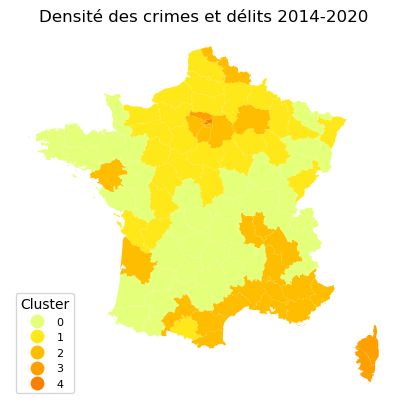

In [82]:
plt.figure(figsize=(12, 8))
vmin, vmax = gdf_departements['Cluster'].min(), gdf_departements['Cluster'].max()
gdf_departements.plot(column='Cluster', legend=True, cmap='Wistia',
                  categorical=True, edgecolor='none',
                  legend_kwds={'fontsize': 8, 'title': "Cluster", 'title_fontsize': 10, 'loc': 'lower left'})
plt.title("Densité des crimes et délits 2014-2020")
plt.axis('off')
plt.show()

On remarque que les départements ayant changé de cluster sont des départements connus pour avoir eu une augmentation récente de la criminalité. Ainsi, on retrouve par exemple une augmentation de la criminalité dans les départements de Nantes, Bordeaux et Grenoble.</br> A noter que les valeurs moyennes des clusters 2 et 3 sont très proches. Ainsi le changement de cluster de la Corse n'est pas si pertinent.